# Homework 3

Your name: Sudheeshna Sampath

Your Andrew ID: sudheess

Collaborators (if none, say \"none\"; do *not* leave this blank): none

# Part 1: Email spam classification [25 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model? 
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [ ]:
#your code here
!pip install -c conda-forge google-colab

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'


**Your answers to the above questions:**
    Answer:
    - The dataset is imbalanced. If the imbalance is not accounted for properly, it will result in lower accuracy in predicting majority and minority class.
    - Choosing proper evaluation metrics such as f1 score (F1 score keeps the balance between precision and recall and improves the score only if the classifier identifies more of a certain class correctly), resampling data, etc

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [104]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
#your code here
import glob
import os
document_list = []
document_label_list=[]
test_doc_list=[]
test_doc_label_list=[]
for foldername in glob.glob(f"/content/drive/MyDrive/Colab Notebooks/email-data/*"):
  for filename in glob.glob(foldername+"/*.txt"):
    if 'testing' not in foldername:
      document_list.append(make_word_list(filename))
      if 'spam' in filename:
        document_label_list.append(1)
      elif 'ham' in filename:
        document_label_list.append(0)
    else:
      test_doc_list.append(make_word_list(filename))
      if 'spam' in filename:
         test_doc_label_list.append(1)
      elif 'ham' in filename:
         test_doc_label_list.append(0)

print("Document List length -Train       : ", len(document_list))
print("Document Label List length -Train : ", len(document_label_list))
print("Document List length -Test        : ", len(test_doc_list))
print("Document Label List length -Test  : ", len(test_doc_label_list))

Document List length -Train       :  5171
Document Label List length -Train :  5171
Document List length -Test        :  100
Document Label List length -Test  :  100


**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [108]:
#your code here

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',max_df=0.8,min_df=50)
X = vectorizer.fit_transform(document_list)
X = X.toarray()
print(len(vectorizer.vocabulary_))

document_label_array = np.array(document_label_list)

1680


**(d) k-NN and random forest: Hyperparameter selection [5 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [15]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [111]:
num_folds = 5
k_fold = KFold(num_folds)
num_features = X.shape[1]
hyperparameter_settings = [(k,max_features, min_samples_leaf)
                            for k in 2**np.arange(0, 8)
                            for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                            for min_samples_leaf in [1, 2, 4, 8, 16]] # fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_score_knn = -np.inf
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    fold_scores_knn=[]
    # your code to train and score the training data here
    best_k,best_max_features,best_min_samples_leaf = hyperparam_setting
    
    for train_index, validation_index in k_fold.split(X):
          train_features = X[train_index]
          train_labels = document_label_array[train_index]
          val_features = X[validation_index]
          val_labels = document_label_array[validation_index]

          knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
          knn_classifier.fit(train_features, train_labels)
          predicted_knn_val_labels = knn_classifier.predict(val_features)
          fold_scores_knn.append(f1_score(val_labels, predicted_knn_val_labels, average='weighted'))

          rf_classifier = RandomForestClassifier(max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=0)
          rf_classifier.fit(train_features, train_labels)
          predicted_val_labels = rf_classifier.predict(val_features)
          
          fold_scores.append(f1_score(val_labels, predicted_val_labels, average='weighted'))
    
    cross_val_score_knn = np.mean(fold_scores_knn)
    if cross_val_score_knn > best_cross_val_score_knn:  # assumes that a higher score is better
        best_cross_val_score_knn = cross_val_score_knn
        best_k = k
        
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting


print('Best hyperparameter setting:', best_hyperparam_setting)

Best hyperparameter setting: (1, 41, 1)


**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

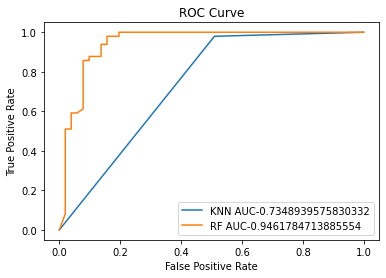

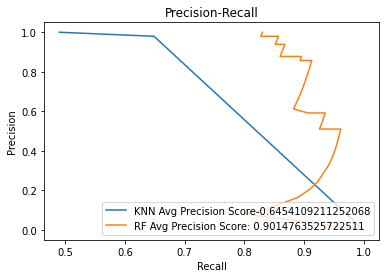

In [ ]:
#your code here
test_doc_label_array = np.array(test_doc_label_list)
best_k, best_max_features, best_min_samples_split = best_hyperparam_setting
#best_k, best_max_features, best_min_samples_split = 1,41,1

#knn
test_X = vectorizer.transform(test_doc_list)
test_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
test_knn_classifier.fit(X, document_label_array)
predicted_knn_test_labels = test_knn_classifier.predict(test_X)
knn_scores = test_knn_classifier.predict_proba(test_X)[:,1]

##random forest
test_rf_classifier = RandomForestClassifier(max_features=best_max_features,min_samples_leaf=best_min_samples_split,random_state=0)
test_rf_classifier.fit(X, document_label_array)
predicted_rf_test_labels = test_rf_classifier.predict(test_X)
rf_scores = test_rf_classifier.predict_proba(test_X)[:,1]

#create ROC curve and AUC
knnfpr, knntpr, knnthreshold  = metrics.roc_curve(test_doc_label_array,  knn_scores)
knnauc = metrics.roc_auc_score(test_doc_label_array,  knn_scores)
plt.plot(knnfpr,knntpr,label="KNN AUC-"+str(knnauc))

rffpr, rftpr, rfthreshold  = metrics.roc_curve(test_doc_label_array,  rf_scores)
rfauc = metrics.roc_auc_score(test_doc_label_array,  rf_scores)
plt.plot(rffpr,rftpr,label="RF AUC-"+str(rfauc))

plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#precision_recall
knnprecision, knnrecall, knnthresholds  = precision_recall_curve(test_doc_label_array, knn_scores)
knn_avg_precision_score = average_precision_score(test_doc_label_array, knn_scores)
plt.plot(knnprecision,knnrecall,label="KNN Avg Precision Score-"+str(knn_avg_precision_score))

rfprecision, rfrecall, rfthresholds  = precision_recall_curve(test_doc_label_array, rf_scores)
rf_avg_precision_score = average_precision_score(test_doc_label_array, rf_scores)
plt.plot(rfprecision,rfrecall,label="RF Avg Precision Score: "+str(rf_avg_precision_score))

plt.title("Precision-Recall")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=4)
plt.show()

Precision Recall Curve is preffered over ROC curve because Precision Recall curve gives better results for imbalanced data. ROC is also overly optimistic in such cases.

Random forest is better than KNN in our chosen curves as dataset imbalanced and random forest can avoid overfitting due to bias. The AUC and Avg Precision Score is higher for Random Forest. 

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

In [ ]:
# !pip install torch==1.10.0
!pip install torch torchvision
!pip install torch torchvision torchaudio
!pip install torchsummaryX
!pip install pytorch-nlp
!pip install torch==1.3.0 torchvision==0.4.1

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/
!python3 UDA_pytorch_utils.py

/content/drive/MyDrive/Colab Notebooks


Let's start with some imports.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

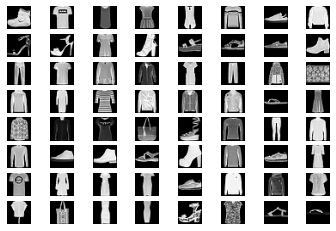

In [42]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [43]:
# write your code here

x_train = torch.tensor([image.numpy() for image, label in train_dataset if label==2 or label==6])
y_train = torch.tensor([label for image, label in train_dataset if label==2 or label==6])
y_train = torch.where(y_train==2,torch.tensor(0),torch.tensor(1))

x_test = torch.tensor([image.numpy() for image, label in test_dataset if label==2 or label==6])
y_test = torch.tensor([label for image, label in test_dataset if label==2 or label==6])
y_test = torch.where(y_test==2,torch.tensor(0),torch.tensor(1))

In [44]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [45]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [46]:
# write your code here
x_train_small =  x_train[random_sample].clone()
y_train_small = y_train[random_sample].clone()

print(x_train_small.shape, y_train_small.shape)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])


**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [47]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt',map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [48]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.891090
[t-SNE] KL divergence after 1000 iterations: 1.064222


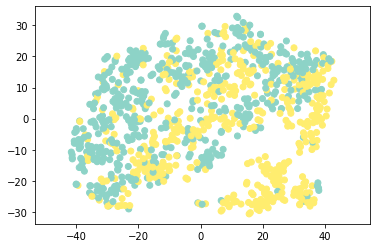

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1000 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.680389
[t-SNE] KL divergence after 1000 iterations: 0.992695


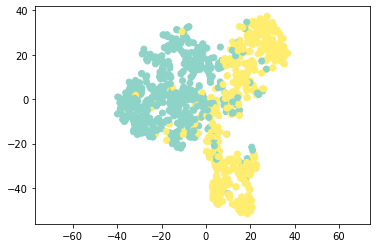

In [49]:
# write your code here
from sklearn.manifold import TSNE

#1
x_train_small_reshaped = x_train_small.reshape(len(x_train_small),-1)
x_train_small_tsned = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0, learning_rate='auto').fit_transform(x_train_small_reshaped)
plt.scatter(x_train_small_tsned[:, 0], x_train_small_tsned[:, 1],c=y_train_small, cmap='Set3')
plt.axis('equal')
plt.show()

#2
x_train_small_bottleneck_representation_tsned = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0, learning_rate='auto').fit_transform(x_train_small_bottleneck_representation)
plt.scatter(x_train_small_bottleneck_representation_tsned[:, 0], x_train_small_bottleneck_representation_tsned[:, 1],c=y_train_small, cmap='Set3')
plt.axis('equal')
plt.show()

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |                     | this cell stays empty|
| 5-NN             |                     |                      |
| Random forest    |                     |                      |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [59]:
# write your code here
from sklearn.metrics import accuracy_score

x_test_reshape = x_test.reshape(len(x_test),-1)
x_test_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)

print("Model Type \t Raw Features \t Bottleneck Features")

predicted_test_labels = UDA_pytorch_classifier_predict(convnet, x_test)
convnet_acc = UDA_compute_accuracy(predicted_test_labels,y_test)*100
print('Pretrained CNN:\t',convnet_acc)

#5-NN classifier trained on all raw training features
test_knn_classifier = KNeighborsClassifier(n_neighbors=5)
test_knn_classifier.fit(x_train_small_reshaped, y_train_small)
predicted_knn_test_labels = test_knn_classifier.predict(x_test_reshape)
knn_acc = accuracy_score(y_test, predicted_knn_test_labels)

#5-NN classifier trained on all training bottleneck features
test_knn_bn_classifier = KNeighborsClassifier(n_neighbors=5)
test_knn_bn_classifier.fit(x_train_small_bottleneck_representation, y_train_small)
predicted_knn_bn_test_labels = test_knn_bn_classifier.predict(x_test_small_bottleneck_representation)
knn_bn_acc = accuracy_score(y_test, predicted_knn_bn_test_labels)

print("5-NN \t \t",knn_acc,"\t \t",knn_bn_acc)

#Random forest trained on all raw training features 
test_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
test_rf_classifier.fit(x_train_small_reshaped, y_train_small)
predicted_rf_test_labels = test_rf_classifier.predict(x_test_reshape)
rf_acc = accuracy_score(y_test, predicted_rf_test_labels)

#Random forest trained on all training bottleneck features
test_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
test_rf_classifier.fit(x_train_small_bottleneck_representation, y_train_small)
predicted_rf_bn_test_labels = test_rf_classifier.predict(x_test_small_bottleneck_representation)
rf_bn_acc = accuracy_score(y_test, predicted_rf_bn_test_labels)

print("Random Forest \t",rf_acc,"\t",rf_bn_acc)

Model Type 	 Raw Features 	 Bottleneck Features
Pretrained CNN:	 0.75
5-NN 	 	 0.819 	 	 0.877
Random Forest 	 0.8525 	 0.8955


Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 5-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

Random Forest with using bottleneck features showed the highest accuracy while pretrained cnn showed the lowest. Overall, the classifiers using bottleneck features had better accuracy than when they used raw features.

**Write your answers here:**

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

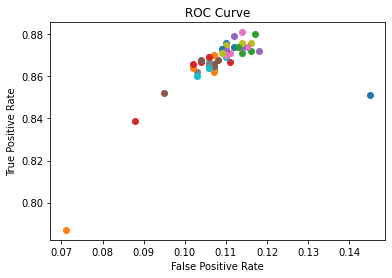

In [103]:
# write your code here
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pandas as pd

fpr_list = []
max_true_pos = 0
best_k=1
for k in np.arange(1,51):
    test_knn_bn_classifier = KNeighborsClassifier(n_neighbors=k)
    test_knn_bn_classifier.fit(x_train_small_bottleneck_representation, y_train_small)
    predicted_knn_test_labels = test_knn_bn_classifier.predict(x_test_small_bottleneck_representation)

    fpr, tpr, _ = roc_curve(y_test,  predicted_knn_test_labels)
    #auc = roc_auc_score(y_test, knn_scores)
  
    plt.scatter(fpr[1],tpr[1],label=k)

    if max_true_pos<tpr[1]:
      if fpr[1]<12.5:
        max_true_pos = tpr[1]
        best_k=k
        fal_pos = fpr[1]
    
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.legend(loc=1)
plt.show()

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:**  7 Nearest Neighbors achieves the highest true positive rate of 88.1% with False Positive rate of 11.5%

In [101]:
# write your code here (if it helps you justify your answer above)
#calculation in above cell
print("K:\tTrue Pos Value  False pos Value")
print(best_k,":\t" ,max_true_pos," \t ",fal_pos)

K:	True Pos Value  False pos Value
7 :	 0.881  	  0.114


# Part 3: Sentiment Analysis [35 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.** We will give full credit even if you subsample the training data. For example, you only work with 5000 randomly chosen training tweets instead of all of them (over 1 million tweets). Also, for the random forest part (the last part), you can keep track of only the most frequently occurring 1000 words (again, this is enough for full credit) and you can also set the RandomForestClassifier argument "n_jobs" to -1 to use all your CPU threads. However, do not subsample the test dataset (which is small anyways).

If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures). Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions:

- Using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

- For the last part, training a random forest for sentiment analysis could be very computationally expensive. If you are already subsampling the training data beforehand, then great, just work with a smaller dataset (note: you should use the same training data for both the LSTM and for the random forest so that the comparison between them is fair). If you want to still try to use the full training dataset or as much of it as possible, then we suggest that you represent the feature vectors as a sparse matrix. You might also want to set the "max_samples" argument to be something like 0.1 so that each tree uses a 10% subsample of the proper training set (with the default choice of 100 trees, across all your trees, you will likely use the vast majority of the full training set---it's just that each tree won't look at more than 10% of the proper training set). Also, simple data splitting suffices; cross-validation here would be very expensive. Moreover, it's fine to not train a random forest from scratch using the best hyperparameters found; instead just use whichever model was trained using the proper training data with the best hyperparameters found.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [5]:
# your code here
path = "/content/drive/MyDrive/Colab Notebooks/HW3-data/train.csv"
import numpy as np

train_data_list = []

with open(path, "r", encoding='iso8859', errors='ignore') as f:
    for line in f:
      sv = line.split(",")
      train_data_list.append(sv)

sentiment_label=[]
sentiment_text =[] 

random_sample_x = np.random.permutation(len(train_data_list))[:5000]

for i,r in enumerate(train_data_list):
  if i in random_sample_x:
    sentiment_label.append(r[0])
    sentiment_text.append(r[5])

positive_sent_label = [x for x in sentiment_label if x=='1']
print("Positive sentiment label:",len(positive_sent_label))

negative_sent_label = [x for x in sentiment_label if x=='0']
print("Negative sentiment label:",len(negative_sent_label))

Positive sentiment label: 2502
Negative sentiment label: 2498


**(b) [20 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [6]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

from torchnlp.encoders.text import SpacyEncoder

train_dataset= list(zip(sentiment_text, sentiment_label))
proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size

proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

encoder = SpacyEncoder([data[0] for data in proper_train_dataset])

proper_train_encoded = [encoder.encode(data[0]) for data in proper_train_dataset]
proper_train_labels = torch.tensor([int(data[1] == '1') for data in proper_train_dataset])

val_encoded = [encoder.encode(data[0]) for data in val_dataset]
val_labels = torch.tensor([int(data[1] == '1') for data in val_dataset])

proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

embedding_weights = torch.empty(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [ ]:
from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 10536]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          1.096226M
Trainable params        42.626k
Non-trainable params    1.0536M
Mult-Adds               42.112k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 10536]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


Epoch 1 [==================================================] 4000/4000
  Train accuracy: 0.5485
  Validation accuracy: 0.5540
Epoch 2 [==================================================] 4000/4000
  Train accuracy: 0.5212
  Validation accuracy: 0.5350
Epoch 3 [==================================================] 4000/4000
  Train accuracy: 0.5130
  Validation accuracy: 0.5310
Epoch 4 [==================================================] 4000/4000
  Train accuracy: 0.5168
  Validation accuracy: 0.5000
Epoch 5 [==================================================] 4000/4000
  Train accuracy: 0.5315
  Validation accuracy: 0.5130
Epoch 6 [==================================================] 4000/4000
  Train accuracy: 0.6817
  Validation accuracy: 0.6300
Epoch 7 [==================================================] 4000/4000
  Train accuracy: 0.5292
  Validation accuracy: 0.5430
Epoch 8 [==================================================] 4000/4000
  Train accuracy: 0.5210
  Validation accuracy:

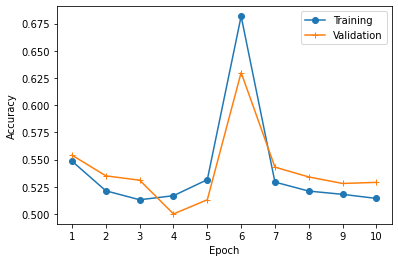

In [ ]:
num_epochs = 10
batch_size = 64  
learning_rate = 0.005

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True,
                               save_epoch_checkpoint_prefix='imdb_lstm')

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.8, min_df=50)
new_train_X = tfid_vectorizer.fit_transform(sentiment_text)
new_train_X = new_train_X.toarray()

In [22]:
new_sentiment_label = [int(data == '1') for data in sentiment_label]
new_sentiment_label_arr = np.array(new_sentiment_label)
new_train_X.shape

(5000, 67)

In [12]:
lowest_cross_val_error = np.inf
best_hyperparameter_setting = None

num_features = new_train_X.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
for hyperparameter_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparameter_setting
    errors = []
    for proper_train_indices, val_indices in kf.split(new_train_X):
        proper_train_features = new_train_X[proper_train_indices]
        proper_train_labels = new_sentiment_label_arr[proper_train_indices]
        val_features = new_train_X[val_indices]
        val_labels = new_sentiment_label_arr[val_indices]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        error = np.mean(predicted_val_labels != val_labels)
        errors.append(error)
        
    cross_val_error = np.mean(errors)
    if cross_val_error < lowest_cross_val_error:
        lowest_cross_val_error = cross_val_error
        best_hyperparameter_setting = hyperparameter_setting

print('Best hyperparameter:', best_hyperparameter_setting, 'cross validation error:', lowest_cross_val_error)

Hyperparameter: (3, 1) cross validation error: 0.4024
Hyperparameter: (3, 2) cross validation error: 0.3914000000000001
Hyperparameter: (3, 4) cross validation error: 0.3934
Hyperparameter: (3, 8) cross validation error: 0.39139999999999997
Hyperparameter: (3, 16) cross validation error: 0.3892
Hyperparameter: (9, 1) cross validation error: 0.4024
Hyperparameter: (9, 2) cross validation error: 0.39980000000000004
Hyperparameter: (9, 4) cross validation error: 0.4018
Hyperparameter: (9, 8) cross validation error: 0.4022
Hyperparameter: (9, 16) cross validation error: 0.3884
Hyperparameter: (33, 1) cross validation error: 0.40599999999999997
Hyperparameter: (33, 2) cross validation error: 0.40360000000000007
Hyperparameter: (33, 4) cross validation error: 0.3994000000000001
Hyperparameter: (33, 8) cross validation error: 0.40099999999999997
Hyperparameter: (33, 16) cross validation error: 0.3884
Best hyperparameter: (9, 16) cross validation error: 0.3884


In [32]:
#Load test data
test_path= "/content/drive/MyDrive/Colab Notebooks/HW3-data/test.csv"
test_data_list = []
with open(test_path, "r", encoding='iso8859', errors='ignore') as f:
    for line in f:
      sv = line.split(",")
      test_data_list.append(sv)

test_sentiment_label=[]
test_sentiment_text =[] 

for i,r in enumerate(test_data_list):
    test_sentiment_label.append(r[0])
    test_sentiment_text.append(r[5])

#vectorize
new_test_X = tfid_vectorizer.transform(test_sentiment_text)
test_sentiment_label_arr = np.array(test_sentiment_label)

In [113]:
#rf on test
best_max_features,best_min_samples_leaf = 9,16 #best_hyperparameter_setting
new_rf_classifier = RandomForestClassifier(max_features=best_max_features,min_samples_leaf=best_min_samples_leaf,random_state=0)
new_rf_classifier.fit(new_train_X, new_sentiment_label_arr)
predicted_rf_test_labels = new_rf_classifier.predict(new_test_X)
rf_acc = accuracy_score(test_sentiment_label, predicted_rf_test_labels)
print("Test Accuracy for Random Forest: ",rf_acc)

Test Accuracy for Random Forest:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
